In [1]:
"""  Import necessary packages """

import rioxarray as rxr
import LoadSaveFunctions as lsf
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import os
import calendar
import pandas as pd
import ipyleaflet
import ipywidgets as ipw

In [2]:
""" select file to open with its path """

file_path = lsf.load_file()

Selected file: /home/grominou/Documents/Recherche/Ressources_geochimie/Isotope_raster_maps/OIPC_geotiff/d18o_11.tif


In [4]:
""" Load and check raster file """

try:
    data = rxr.open_rasterio(file_path, masked=True)
    print("Geotiff file loaded successfully.")
    print(data)
except Exception as e:
    print(f"Error loading the Geotiff file: {e}")

# View generate metadata associated with the raster file
print("The crs of your data is:", data.rio.crs)
print("The nodatavalue of your data is:", data.rio.nodata)
print("The shape of your data is:", data.shape)
print("The spatial resolution for your data is:", data.rio.resolution())
print("The metadata for your data is:", data.attrs)
print("The spatial extent of this data is: ", data.rio.bounds())

Geotiff file loaded successfully.
<xarray.DataArray (band: 1, y: 2083, x: 4320)> Size: 36MB
[8998560 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 35kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y            (y) float64 17kB 83.54 83.46 83.37 ... -89.79 -89.88 -89.96
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  4.7468786239624
    STATISTICS_MEAN:     1.#SNAN
    STATISTICS_MINIMUM:  -57.662677764893
    STATISTICS_STDDEV:   1.#SNAN
    scale_factor:        1.0
    add_offset:          0.0
The crs of your data is: GEOGCS["unknown",DATUM["Unknown based on WGS84 ellipsoid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
The nodatavalue of your data is: nan
The shape of your data is: (1, 2083, 4320)
The spatial resolution for your dat

In [ ]:
""" Plot raster and add specific datapoint """

lat_point = 45
lon_point = 5

f, ax = plt.subplots(figsize=(10, 4))
data.plot(ax=ax, cmap = 'seismic')
ax.set(title="Map of stable isotope values", xlabel='Longitude (°)', ylabel='Latitude (°)', facecolor = 'gray')
ax.plot(lon_point, lat_point, "or")

# Acces first band of the raster file window
first_band = data.sel(band=1)
value_at_point = first_band.sel(x=lon_point, y=lat_point, method="nearest").values
ax.text(lon_point - 5, lat_point + 5, f"δx={value_at_point:.2f}‰", color='black', fontsize=12)

plt.show()

In [ ]:
""" Plot histogram of values """

f, ax = plt.subplots(figsize=(8, 5))
data.plot.hist(ax=ax, color="purple", bins=30, edgecolor='white')
ax.set(title="Distribution of stable isotope values",
       xlabel='Stable isotope compositions (‰ V-SMOW)',
       ylabel='Frequency')
plt.show()

print("The minimum raster value is: ", np.nanmin(data.data))
print("The maximum raster value is: ", np.nanmax(data.data))

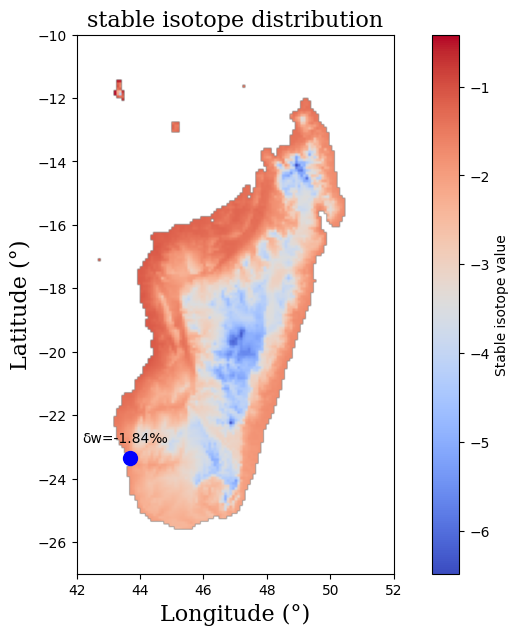

In [ ]:
""" Plot a limited area of the raster """

# Define font
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }


# set window bounds as geographic coordinates (minlong, minlat, maxlong, maxlat)
# minlong, minlat, maxlong, maxlat = (-5, 41, 9, 52)
# minlong, minlat, maxlong, maxlat = (100, 1000, 100, 1000)
minlong, minlat, maxlong, maxlat = (42, -27, 52, -10)   #Madagascar

# extract selected window
window = data.rio.clip_box(minx=minlong, miny=minlat, maxx=maxlong, maxy=maxlat, allow_one_dimensional_raster=True)

# Acces first band of the raster file window
first_band = window.sel(band=1)

# Plot the band within the selected window
plt.figure(figsize=(10, 7))
plt.imshow(first_band, cmap='coolwarm', extent=[minlong, maxlong, minlat, maxlat])
plt.colorbar(label="Stable isotope value")
plt.title("stable isotope distribution", loc='center', fontdict=font)
plt.xlabel("Longitude (°)", fontdict=font)
plt.ylabel("Latitude (°)", fontdict=font)

# add specific point plot and show its band value
Lyon = [45.75, 4.83]
Paris = [48.86, 2.35]
Brest = [48.40, -4.48]
Strasbourg = [48.58, 7.75]
Bozeman = [45, -111]
Toliara = [-23.35, 43.67]

lat_point, lon_point = Toliara
value_at_point = first_band.sel(x=lon_point, y=lat_point, method="nearest").values
plt.scatter(lon_point, lat_point, color='blue', marker='o', s=100, label=f"Point ({lon_point}, {lat_point})")
plt.text(lon_point - 1.5, lat_point + 0.5, f"δw={value_at_point:.2f}‰", color='black', fontsize=10)
plt.savefig("map.png")

plt.show()

In [ ]:
""" Create a map from openstreetmap centered on given coordinates (latitude, longitude) that we can browse and click to get coordinates """

# Defining global variables to store latitude, longitude and marker state
lat = None
lon = None
current_marker = None

# Create map centered on given coordiantes
center = [45.7586, 4.8333]  # Lyon
mymap = ipyleaflet.Map(basemap=ipyleaflet.basemaps.Esri.WorldStreetMap, center=center, zoom=3, layout=ipw.Layout(width='1000px', height='600px'), scroll_wheel_zoom = True)


# HTML widget to display coordinates
coord_label = ipw.HTML("Click on map to get coordiantes")
coord_label.value = "Coordinates : "

# Function to get coordinates by clicking on the map
def on_map_interaction(**kwargs):
    global lat, lon, current_marker
    if kwargs.get('type') == 'click':
        lat, lon = kwargs.get('coordinates')
        coord_label.value = f"Coordonnées : Latitude {lat}, Longitude {lon}"

        # Remove existing current marker
        if current_marker is not None:
            mymap.remove_layer(current_marker)
        
        # Create new marker on click position
        current_marker = ipyleaflet.Marker(location=(lat, lon))
        mymap.add_layer(current_marker)

# link interaction event with function
mymap.on_interaction(on_map_interaction)

# Display map and widget
ui = ipw.VBox([coord_label, mymap])
ui




In [ ]:
""" Create Panda dataframe of d18O and d2H using clicked position from the map """

# Create function to open all ratserfiles (months, mean annual, and associated standard errors), extract isotope values at provided coordinates and organize them in a pandas dataframe
def extract_isotope_data_from_position(lon=4.83, lat=45.75):

    def get_data(x, y, file_name, i):
        if not "MA" in file_name:
            file = os.path.join(folder_path, '')+file_name+"{:02}.tif".format(i+1)
        else:
            file = os.path.join(folder_path, '')+file_name+".tif".format(i+1)
        with rio.open(file) as dataset:
            x, y = map(int, rio.transform.rowcol(dataset.transform, lon, lat))
            value = dataset.read(1)[x, y]
        return value
    
    
    folder_path = lsf.load_folder()
    file_name = ("d18o_", "d18o_MA", "d18o_se_", "d18o_se_MA", "d2h_", "d2h_MA", "d2h_se_", "d2h_se_MA")
     
    data_table = pd.DataFrame(columns=["Period", "δ18O", "s.e.", "δ2H", "s.e."])
    for i in range(13):
        if i < 12:
            isoo = get_data(lon, lat, file_name[0], i)
            erroro = get_data(lon, lat, file_name[2], i)
            isoh = get_data(lon, lat, file_name[4], i)
            errorh = get_data(lon, lat, file_name[6], i)
            data_table.loc[len(data_table)] = [calendar.month_name[i+1], round(isoo, 2), round(erroro, 2), round(isoh, 2), round(errorh, 2)] 
        else:
            isoo = get_data(lon, lat, file_name[1], i)
            erroro = get_data(lon, lat, file_name[3], i)
            isoh = get_data(lon, lat, file_name[5], i)
            errorh = get_data(lon, lat, file_name[7], i)
            data_table.loc[len(data_table)] = ["Mean annual", round(isoo, 2), round(erroro, 2), round(isoh, 2), round(errorh, 2)] 

    return data_table

tableiso = extract_isotope_data_from_position(lon, lat)
display(tableiso)
